# Analysis Setup 

In [4]:
%load_ext lab_black

In [5]:
from tqdm import trange
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sb

colors = ["dark blue", "faded blue", "steel blue", "faded green", "faded red"]
cmap = sb.xkcd_palette(colors)
import warnings

warnings.simplefilter("ignore")

In [50]:
#### SAVING FIGURES
## the default savefig params can be different from the display params
## e.g., you may want a higher resolution, or to make the figure
## background white
import matplotlib as mpl
import os

mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "small"
# savefig.dpi         : figure   ## figure dots per inch or 'figure'
mpl.rcParams["savefig.dpi"] = 300
# savefig.facecolor   : white    ## figure facecolor when saving
# savefig.edgecolor   : white    ## figure edgecolor when saving
# savefig.format      : png      ## png, ps, pdf, svg
mpl.rcParams["savefig.format"] = "eps"
# savefig.bbox        : standard ## 'tight' or 'standard'.
## 'tight' is incompatible with pipe-based animation
## backends but will workd with temporary file based ones:
## e.g. setting animation.writer to ffmpeg will not work,
## use ffmpeg_file instead
mpl.rcParams["savefig.bbox"] = "tight"
# savefig.pad_inches  : 0.1      ## Padding to be used when bbox is set to 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.02
# savefig.jpeg_quality: 95       ## when a jpeg is saved, the default quality parameter.
paper_path = "../plots/"
plain_model_output = "../data/plain_model_output/"
results_path = "../data/results/"

In [7]:
sb.set_context("talk")

In [8]:
longname_diag = dict()
longname_diag["co2_flx_land"] = "diag. atm. CO$_{2}$ due to land"
longname_diag["co2_flx_ocean"] = "diag. atm. CO$_{2}$ due to ocean"

In [9]:
units = dict()
units["combined"] = "ppm"
units["ocean"] = "ppm"
units["land"] = "ppm"
units["tsurf"] = "$^\circ$C"
units["co2_flux"] = "PgC/yr"
units["co2_flx_land"] = "PgC/yr"
units["co2_flx_ocean"] = "PgC/yr"

longname = dict()
longname["combined"] = "diag. CO$_{2,atm}$"
longname["land"] = "diag. CO$_{2,atm}$ due to land"
longname["ocean"] = "diag. CO$_{2,atm}$ due to ocean"
longname["tsurf"] = "GMST"
longname["co2_flux"] = "CO$_2$ flux"
longname["co2_flx_land"] = "ocean CO$_2$ flux"
longname["co2_flx_ocean"] = "land CO$_2$ flux"

In [10]:
sig = 95
psig = sig / 100
lcil = ((100 - sig) / 2) / 100
ucil = 1 - lcil

## Load from file

In [12]:
co2atm_forcing = (
    xr.open_dataset(plain_model_output + "co2atm.nc")
    .drop("member")
    .rename({"ext": "member", "year": "time"})
)
cf = xr.open_dataset(plain_model_output + "GE_co2_flux.nc").rename(
    {"member": "initialization", "ext": "member", "year": "time"}
)

In [35]:
# same data but different naming for different purposes
gmst = xr.open_dataset(plain_model_output + "GE_GMST_ym.nc").rename(
    {"ens": "initialization", "ext": "member", "year": "time"}
)
gmst_cdo = xr.open_dataset(plain_model_output + "GE_GMST_ym.nc").rename(
    {"ens": "member"}
)

In [14]:
c4mip = xr.open_dataset(plain_model_output + "CMIP6_C4MIP_ensemble_CO2_co2_flux.nc")

#### pre-defined functions

In [15]:
def yearmonmean(ds):
    return ds.groupby("time.year").mean("time").rename({"year": "time"})


def standardize(ds, dim="time"):
    return (ds - ds.mean(dim)) / ds.std(dim)


from esmtools.stats import linregress


def linear_detrend(cf, end=2005, start=1850, dim="time"):
    if isinstance(cf, xr.Dataset):
        varl = []
        for var in cf.data_vars:
            detrended = remove_trend(cf[var], end=end, start=start, dim=dim)
            detrended.name = var
            varl.append(detrended)
        cf_detrended = xr.merge(varl)
    else:
        cf_detrended = remove_trend(cf)
    return cf_detrended


def remove_trend(ds, start=1850, end=2005, dim="time"):
    res = linregress(
        ds.sel(time=slice(start, end))[dim], ds.sel(time=slice(start, end))
    )
    lfit = res["intercept"] + res["slope"] * ds.time
    detrended = ds - lfit + ds.mean("time")
    return detrended

### Setting the context
#### Evolution of Historical and RCPs

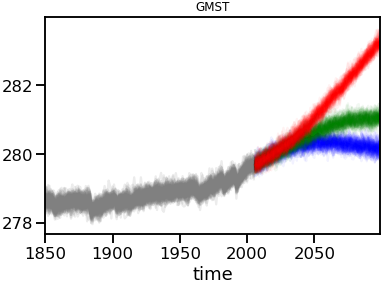

In [37]:
cmape = ["b", "g", "r"]
fig, ax = plt.subplots()
ax.set_title("GMST")
gmst.sel(time=slice(1850, 2005)).isel(member=1).to_dataframe().unstack(0)["tsurf"].plot(
    ax=ax, color="gray", legend=False, alpha=0.15
)
for i, m in enumerate(gmst.member.values):
    gmst.sel(time=slice(2006, 2099)).sel(member=m).to_dataframe().unstack(0)[
        "tsurf"
    ].plot(ax=ax, color=cmape[i], legend=False, alpha=0.05)

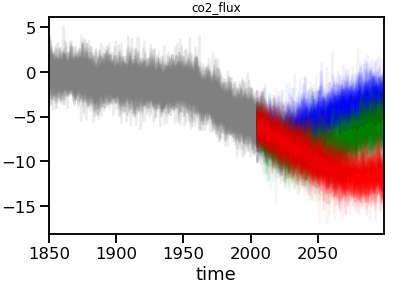

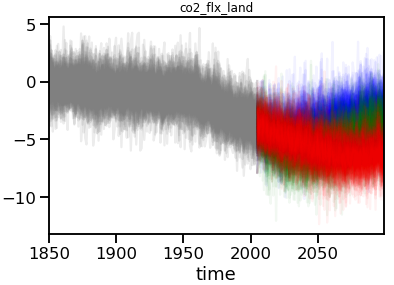

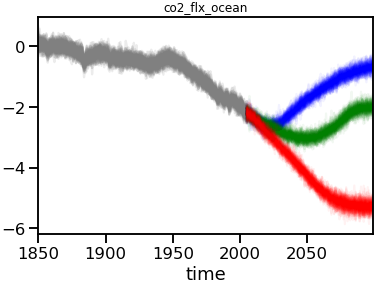

In [38]:
carbon_fluxes = cf.to_dataframe()

all_ext = ["rcp26", "rcp45", "rcp85"]
for varname in carbon_fluxes.columns:
    fig, ax = plt.subplots()
    carbon_fluxes[varname].unstack(1)[all_ext[1]].unstack(0).loc[:2005].plot(
        ax=ax, color="gray", legend=False, alpha=0.15
    )
    for i, ext in enumerate(all_ext):
        carbon_fluxes[varname].unstack(1)[ext].unstack(0).loc[2005:].plot(
            ax=ax, color=cmape[i], legend=False, alpha=0.05
        )
    ax.set_title(varname)

#### atm. CO$_2$ forcing

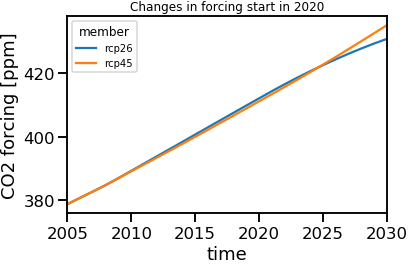

In [39]:
end = 2030
co2atm_forcing.sel(member=["rcp26", "rcp45"]).sel(
    time=slice(2005, end)
).to_dataframe().unstack(0)["co2atm"].plot(title="Changes in forcing start in 2020")
plt.ylabel("CO2 forcing [ppm]")
plt.tight_layout()
# plt.savefig('co2_forcing')

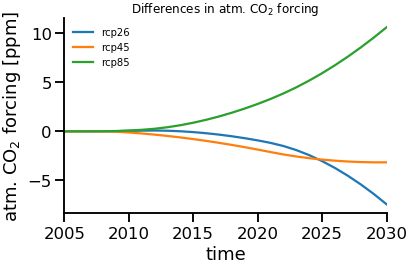

In [40]:
(co2atm_forcing - co2atm_forcing.mean("member")).sel(
    time=slice(2005, end)
).to_dataframe().unstack(0)["co2atm"].plot(title="Differences in atm. CO$_2$ forcing")
plt.ylabel("atm. CO$_2$ forcing [ppm]")
plt.tight_layout()
plt.legend(frameon=False)
sb.despine()
# plt.savefig('co2_forcing_diff2')
plt.show()

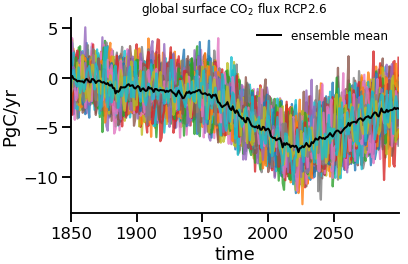

In [41]:
v = "co2_flux"
cf.isel(member=0)[v].to_dataframe().unstack().plot(legend=False, alpha=0.8)
m = (
    cf.isel(member=0)[v]
    .mean("initialization")
    .plot(label="ensemble mean", color="k", lw=2, ax=plt.gca())
)
plt.title("global surface CO$_2$ flux RCP2.6")
plt.ylabel("PgC/yr")
plt.legend(m, ["ensemble mean"], fontsize=12, frameon=False)
plt.tight_layout()
sb.despine()
# plt.savefig('co2_flux_evolution')

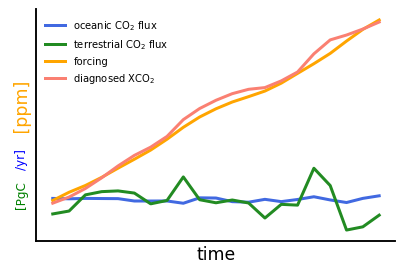

In [42]:
start = 1980
end = 2000
lw = 3
iv = (
    (cf["co2_flx_ocean"] - cf["co2_flx_ocean"].mean("initialization"))
    .isel(initialization=0, member=0)
    .sel(time=slice(start, end))
)
(iv * 2).plot(color="royalblue", lw=lw, label="oceanic CO$_2$ flux")
iv = (
    (cf["co2_flx_land"] - cf["co2_flx_land"].mean("initialization"))
    .isel(initialization=0, member=0)
    .sel(time=slice(start, end))
)
(iv * 2).plot(color="forestgreen", lw=lw, label="terrestrial CO$_2$ flux")
iv = (
    (cf["co2_flux"] - cf["co2_flux"].mean("initialization"))
    .isel(initialization=0, member=0)
    .sel(time=slice(start, end))
)
f = (
    (co2atm_forcing["co2atm"] - co2atm_forcing["co2atm"].sel(time=start))
    .isel(member=0)
    .sel(time=slice(start, end))
)
f.plot(color="orange", lw=lw, label="forcing")
comb = f + iv.cumsum("time") / 2.12
comb.plot(color="salmon", lw=lw, label="diagnosed XCO$_2$")
plt.ylabel("       [ppm]", color="orange", fontsize="x-large")
plt.title("")
plt.xlabel("time", fontsize="x-large")
plt.legend(frameon=False)
plt.xticks([], [])
plt.yticks([], [])
x = 0.037
plt.annotate(
    "/yr]",
    xy=(x, 0.4),
    xycoords="figure fraction",
    rotation=90,
    fontsize="medium",
    color="blue",
)
plt.annotate(
    "[PgC",
    xy=(x, 0.28),
    xycoords="figure fraction",
    rotation=90,
    fontsize="medium",
    color="green",
)
plt.tight_layout()
sb.despine()
plt.savefig(paper_path + "FigureSI_diag_atm_CO2_schema")

### Investigating internal variability

In [43]:
# first removing drift with subtracting rolling 50 yr mean
roll = 50
rolld2 = roll // 2
cf_internal_variability = cf - cf.rolling(time=roll, center=True).mean().isel(
    time=slice(rolld2, -rolld2)
)
cf_internal_variability = cf_internal_variability - cf_internal_variability.mean(
    "initialization"
)

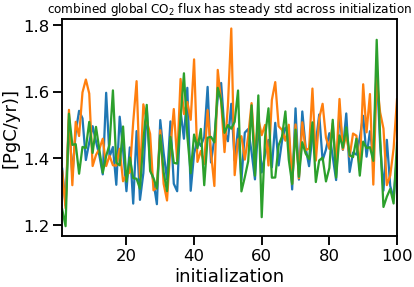

In [44]:
cf_internal_variability.std("time").to_dataframe()["co2_flux"].unstack().plot(
    legend=False,
    title="combined global CO$_2$ flux has steady std across initialization",
)
plt.ylabel("[PgC/yr)]")
plt.show()

# Diagnosing atmospheric CO$_2$ concentrations
We initialize each member inidividually when carbon-neutral (going through 0 PgC)

Inventory change in Ocean/Land at the atmospheric surface result in atmospheric CO2 inventory and thereby change atm. CO2 concentration.

As atm. CO2 is prescribed in historical simulations, I diagnose the internal variability of CO$_2$ from the time-accumulated internal variability of the global surface CO$_2$ fluxes. 

Assuming that global CO$_2$ fluxes in PgC=GtC spread in the global atmosphere: 1ppm = 2.12 GtC = 2.12 PgC [Le Quere2018, Doney2006, many others]

Formula:

$pCO_{2,atm,diag}(t) = pCO_{2,atm,forcing}(t) + \sum^t_{t'=1850} \overline{\text{CO$_2$ flux}(t')}\frac{ppm}{2.12PgC}$

The $\overline{\text{overline}}$ denotes zero-mean, zero-trend CO$_2$ flux which is achieved by remove the ensemble member mean and time mean. 

Assumptions:
- atm. CO$_2$ concentrations are driven by emissions and the carbon feedbacks. Inter-annual variability (with the forced signal removed) is due to climate variability only.
- feedback of internal variability of atm. CO$_2$ on CO$_2$ fluxes is negligible:
  - CO$_2$ flux variability is driven by large-scale modes of internal climate variability
  - this assumption also made in CMIP5 historical simulations
- inter-annual variability of atm. CO$_2$ doesn't affect radiation scheme:
  - this assumption is also made in CMIP5 historical simulations

#### Diagnose by initializing each member at equil. cum. CO2 flux

In [51]:
fac = 2.13
v = "co2_flux"

In [52]:
# initialize every member at its own carbon neutral time in historical (therefore member=0)
flex_inits = (
    cf_internal_variability.isel(member=0).drop("member")[v].sel(time=slice(1850, 2005))
)

Text(0, 0.5, 'PgC/yr')

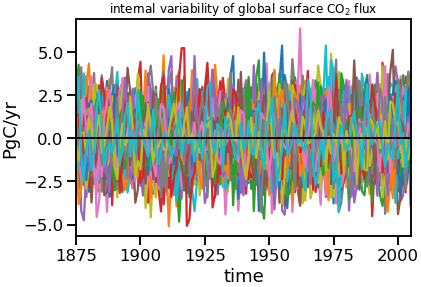

In [53]:
flex_inits.to_dataframe().unstack().plot(legend=False)
flex_inits.mean("initialization").to_dataframe().plot(
    legend=False, color="k", lw=2, ax=plt.gca()
)
plt.title("internal variability of global surface CO$_2$ flux")
plt.ylabel("PgC/yr")

In [54]:
# standardize to find close to neutral easier
standardized = (flex_inits - flex_inits.mean("time")) / flex_inits.std("time")
# standardized.to_dataframe().unstack().plot(legend=False)

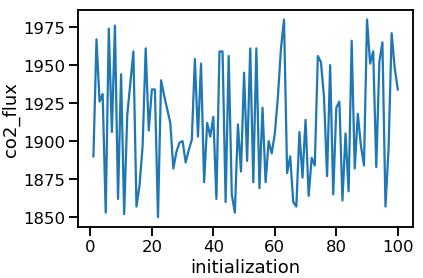

In [55]:
# where every member is close to carbon neutral (defined as less than .1*std away)
# quick plot
(standardized.where(np.abs(standardized) < 0.1).argmax("time") + 1850).plot()

In [56]:
def find_neutral_IC(cf, v="co2_flux", i=1, diff=0.1):
    """Find neutral detrended co2_flux cumsum (smaller than diff*std) initial conditions year."""
    # for each member individually
    onem = (
        (cf - cf.mean("initialization"))
        .isel(member=0)
        .isel(initialization=i)
        .sel(time=slice(1850, 2005))[v]
    )
    onem = onem - onem.mean("time")
    # aggregate over time
    onemc = (onem).cumsum("time") / 2.13
    onemc["time"] = onem.time
    onemc_std = standardize(onemc)
    return onemc_std.where(np.abs(onemc_std) < diff).dropna("time").time.values[-1]

In [57]:
neutral_year = dict()
for i in range(0, 100):
    res = find_neutral_IC(cf, i=i)
    print(i, res)
    neutral_year[i + 1] = res

0 1995
1 1997
2 2003
3 2002
4 2004
5 1994
6 1996
7 2005
8 1982
9 1971
10 1983
11 2000
12 1975
13 1992
14 1991
15 2003
16 2005
17 2001
18 2000
19 2001
20 2001
21 1966
22 2003
23 1942
24 1951
25 2005
26 2000
27 1987
28 1949
29 2004
30 1994
31 1992
32 1987
33 1953
34 2001
35 1972
36 1978
37 2005
38 2002
39 2002
40 1995
41 1998
42 1991
43 2003
44 2004
45 1986
46 1990
47 2005
48 1984
49 1985
50 2004
51 1987
52 1926
53 1981
54 1974
55 1964
56 2004
57 2005
58 1998
59 1994
60 2000
61 2000
62 2005
63 1957
64 1987
65 2003
66 2003
67 1986
68 2003
69 1987
70 2004
71 1991
72 1992
73 1988
74 1995
75 2003
76 1993
77 2005
78 2005
79 1919
80 2005
81 1994
82 1987
83 1999
84 1997
85 2002
86 2005
87 1995
88 1983
89 1986
90 2003
91 1999
92 1997
93 1995
94 2002
95 1967
96 1956
97 1967
98 1996
99 1996


In [58]:
def individual_init(cf_internal_variability, i=90, plot=False):
    """Initialize a member i in its latest carbon neutral year in the historical."""
    end = 2070
    c = cf_internal_variability.sel(initialization=i).isel(member=0)[v]
    if plot:
        c.plot()

    init = (c).sel(time=slice(neutral_year[i] + 1, 2004)).sum("time") / 2.13
    #   member, initialized in 2005 value, neutral year
    print(i, init.values, neutral_year[i])
    # units:        ppm                                          ppm        ppm
    d = (
        co2atm_forcing["co2atm"].sel(time=slice(2005, end))
        + init.values
        + cf_internal_variability.sel(time=slice(2005, end))
        .sel(initialization=i)
        .cumsum("time")
        / 2.13
    )
    d["time"] = cf_internal_variability.sel(time=slice(2005, end)).time

    if plot:
        d.to_dataframe().unstack(0)[v].plot()
    return d

In [59]:
# initialize every member
res = []
for i in cf_internal_variability.initialization.values:
    res.append(individual_init(cf_internal_variability, i=i))
diagnosed = xr.concat(res, "initialization")
diagnosed["initialization"] = cf_internal_variability.initialization.values

1 0.24404741990514595 1995
2 -3.110839526483232 1997
3 0.0429582419294559 2003
4 0.984090041602762 2002
5 0.0 2004
6 0.7170623895427034 1994
7 -1.1334142111626242 1996
8 0.0 2005
9 -0.8269483273120529 1982
10 -2.6118339526242558 1971
11 0.6290315225533255 1983
12 -1.289022083774778 2000
13 1.120819144876233 1975
14 1.181676151183098 1992
15 -0.3967021302170552 1991
16 -0.3894153519900103 2003
17 0.0 2005
18 -0.45829132734283645 2001
19 0.960625176216671 2000
20 -2.4850746999696263 2001
21 -0.2482901376435326 2001
22 -0.864163417022472 1966
23 1.2108910585747463 2003
24 -1.551246030669956 1942
25 1.6995040643215824 1951
26 0.0 2005
27 -0.7286782600933425 2000
28 -0.6316182333337012 1987
29 1.9841335968097538 1949
30 0.0 2004
31 -1.528951755940444 1994
32 -0.4852433435748547 1992
33 1.7823480037278763 1987
34 0.03430809119501586 1953
35 2.247651021658513 2001
36 2.3926354198834776 1972
37 1.10327387273546 1978
38 0.0 2005
39 -1.5765319781926326 2002
40 -1.324659094429881 2002
41 0.244833

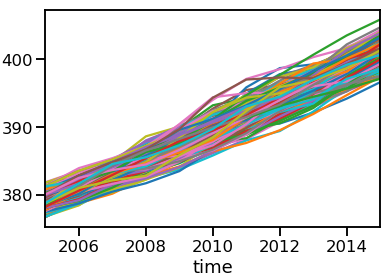

In [60]:
v = "co2_flux"
diagnosed.sel(time=slice(2005, 2015))[v].to_dataframe().unstack(0).unstack(0)[v].plot(
    legend=False
)

In [61]:
diagnosed_int_var = diagnosed - co2atm_forcing["co2atm"]

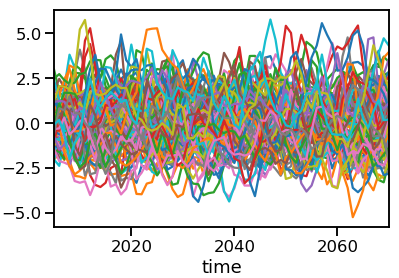

In [62]:
diagnosed_int_var["co2_flux"].isel(member=1).to_dataframe()["co2_flux"].unstack(0).plot(
    legend=False
)

,diag. atm. CO$_2$
count,100.00
mean,-0.00
std,1.09
min,-2.07
25%,-0.77
50%,-0.01
75%,0.68
max,2.94


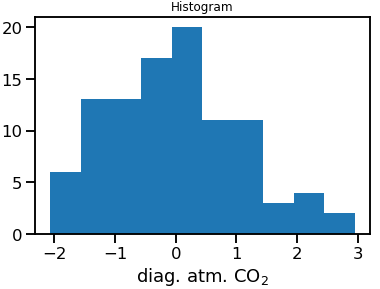

In [63]:
# distribution of diagnosed atm CO2 in 2005 anomaly to mean
hist = (
    (diagnosed - diagnosed.mean("initialization"))
    .sel(time=slice(2005, 2005))
    .sel(member=["rcp45"])["co2_flux"]
)
hist.name = "diag. atm. CO$_2$"
hist.plot.hist()
hist.to_dataframe().describe().round(2)

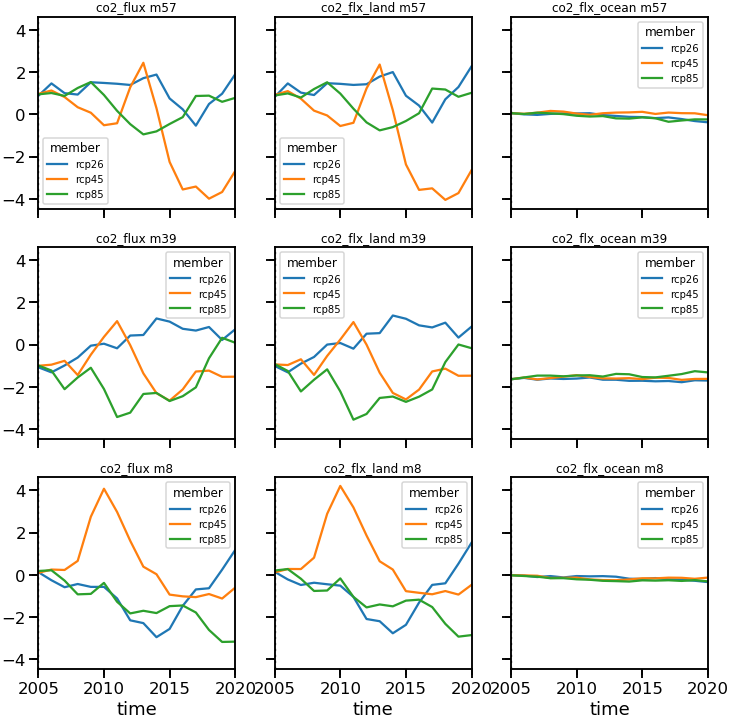

In [64]:
# quick check on individual members
int_var = True
n = 3
random_members = np.random.randint(1, 100, n)
# varname = 'ocean'
fig, ax = plt.subplots(
    ncols=3, nrows=n, figsize=(3 * 4, n * 4), sharex=True, sharey=True
)
for i, m in enumerate(random_members):
    if int_var:
        t = diagnosed_int_var
    else:
        t = diagnosed
    for j, varname in enumerate(t.data_vars):
        t.sel(initialization=m)[varname].drop("initialization").sel(
            time=slice(2000, 2020)
        ).to_dataframe()[varname].unstack(0).plot(
            title=" ".join([varname, "m" + str(m)]), ax=ax[i, j]
        )
        ax[i, j].axvline(x=2005, ls=":", c="k")

In [65]:
diagnosed.to_netcdf(results_path + "GE_diagnosed_atm_CO2.nc")

In [66]:
def diagnose_early_to_2004(cf_internal_variability, diagnosed, i=2, s=1880, e=2005):
    """Diagnose atm. CO$_2$ for historical period initialized with the 2005 values."""
    init = (
        diagnosed.sel(time=2005)["co2_flux"].isel(member=0)
        - co2atm_forcing["co2atm"].sel(time=2005, member="rcp26").values
    )
    diag_before = (
        co2atm_forcing["co2atm"].sel(time=slice(s, e))
        + init
        + cf_internal_variability.sel(time=slice(s, e)).cumsum("time") / 2.13
    )
    diag_before["time"] = cf_internal_variability.sel(time=slice(s, e)).time
    # adjust diag_before to diagnosed
    offset = (
        diagnosed["co2_flux"].isel(member=0).sel(time=2005).squeeze()
        - diag_before["co2_flux"].isel(member=0).sel(time=2005).squeeze()
    )
    diag_before = diag_before + offset
    return diag_before


diagnosed_all = xr.concat(
    [
        diagnose_early_to_2004(cf_internal_variability, diagnosed, i=2).sel(
            time=slice(1880, 2004)
        ),
        diagnosed,
    ],
    "time",
)

### Figure 1

In [67]:
import PMMPIESM

# download data
GM = (
    PMMPIESM.load.CO2_global_mean()
    .groupby("time.year")
    .mean("time")
    .rename({"year": "time"})
)
GMGR = GM.diff("time").to_dataframe("GM")
MLO = (
    PMMPIESM.load.CO2_Mauna_Loa()
    .groupby("time.year")
    .mean("time")
    .rename({"year": "time"})
)
MLOGR = MLO.sel(time=slice("1980", None)).diff("time").to_dataframe("MLO")

xesmf import error
check https://xesmf.readthedocs.io/en/latest/installation.html


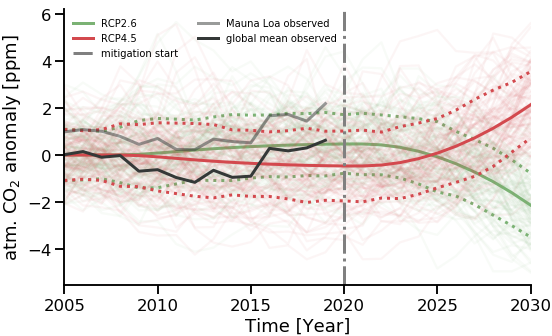

In [68]:
colors = ["faded green", "faded red", "charcoal"]
cmap = sb.xkcd_palette(colors)

end = 2030
forcing = 0
forcing = (
    diagnosed["co2_flux"]
    .sel(time=slice(2005, end))
    .isel(member=[0, 1])
    .mean("member")
    .mean("initialization")
)
fig, ax = plt.subplots(figsize=(8, 5))
handles = []
for i in range(2):
    (diagnosed - forcing)["co2_flux"].sel(time=slice(2005, end)).isel(
        member=i
    ).to_dataframe()["co2_flux"].unstack(0).plot(
        ax=ax, alpha=0.05, c=cmap[i], legend=False
    )
    mean = (
        (diagnosed - forcing)["co2_flux"]
        .sel(time=slice(2005, end))
        .isel(member=i)
        .mean("initialization")
    )
    std = (
        (diagnosed - forcing)["co2_flux"]
        .sel(time=slice(2005, end))
        .isel(member=i)
        .std("initialization")
    )
    (m,) = mean.plot(c=cmap[i], lw=3)
    handles.append(m)
    (mean + std).plot(c=cmap[i], lw=3, ls=":")
    (mean - std).plot(c=cmap[i], lw=3, ls=":")
ms = ax.axvline(x=2020, ls="-.", lw=3, c="gray")

# obs
(gmo,) = (GM - forcing).plot(c=cmap[2], lw=3)
(mlo,) = (MLO - forcing).plot(c=cmap[2], lw=3, alpha=0.5)

ax.legend(
    handles + [ms, mlo, gmo],
    [
        "RCP2.6",
        "RCP4.5",
        "mitigation start",
        "Mauna Loa observed",
        "global mean observed",
    ],
    frameon=False,
    ncol=2,
    fontsize="small",
)
sb.despine()
plt.ylabel("atm. CO$_2$ anomaly [ppm]")
plt.xlabel("Time [Year]")
plt.tight_layout()
plt.savefig(paper_path + "Figure1_co2_forcing_diff.png")

### Figure SI1: Verification of diagnosed

In [69]:
def diagnose_emission_driven(ds):
    co2_flux = ds["co2_flux"]
    co2_flux = co2_flux - co2_flux.mean("member")
    non_zero_comp = co2_flux.sel(time=slice("1850", "1870")).mean(["time", "member"])
    # print(non_zero_comp)
    co2_flux = co2_flux - non_zero_comp
    diag = co2_flux.cumsum("time") / 2.12
    ds["diagnosed"] = diag + ds["CO2"].mean("member")
    return ds

In [70]:
d = yearmonmean(diagnose_emission_driven(c4mip)["diagnosed"])

In [71]:
c4mip_ym = yearmonmean(c4mip)

In [72]:
forcing = c4mip_ym["CO2"].mean("member")
# forcing=0

member 1 ACC 0.997 RMSE 0.152 MAE 0.134
member 2 ACC 0.998 RMSE 0.091 MAE 0.076
member 3 ACC 0.989 RMSE 0.167 MAE 0.139
member 4 ACC 0.992 RMSE 0.130 MAE 0.109
member 5 ACC 0.994 RMSE 0.142 MAE 0.129
member 6 ACC 0.993 RMSE 0.146 MAE 0.118
member 7 ACC 0.991 RMSE 0.137 MAE 0.113
member 8 ACC 0.995 RMSE 0.165 MAE 0.147
member 9 ACC 0.995 RMSE 0.224 MAE 0.207


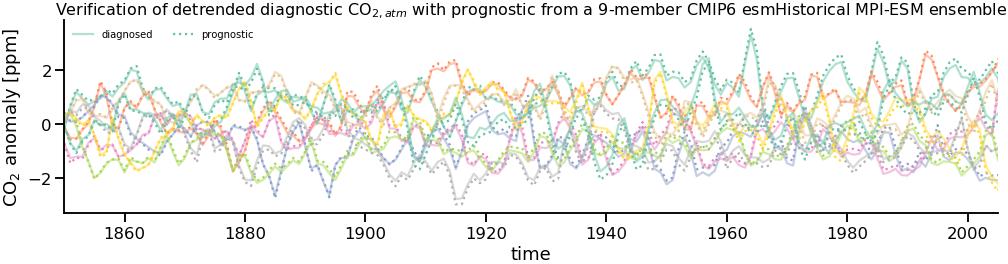

In [73]:
import xskillscore as xs

r_mae = []
r_rmse = []
r_pearson_r = []
cmap = sb.color_palette("Set2", c4mip.member.size)
fig, ax = plt.subplots(figsize=(15, 4))
for i, m in enumerate(d.member):
    # print(m.values)
    a = d.sel(member=m) - forcing
    p1 = a.plot(label="diagnosed", c=cmap[i], alpha=0.5)
    b = c4mip_ym.sel(member=m)["CO2"] - forcing
    b = b - b.isel(time=0) + a.isel(time=0)
    p2 = b.plot(label="prognostic", c=cmap[i], ls=":")
    plt.title(int(m.values))
    r = xs.mae(a, b, "time")
    # print(f"mae {r.values:.3f}")
    r_mae.append(r)
    r = xs.rmse(a, b, "time")
    # print(f"rmse {r.values:.3f}")
    r_rmse.append(r)
    r = xs.pearson_r(a, b, "time")
    print(
        f"member {int(m)} ACC {r.values:.3f} RMSE {r_rmse[-1].values:.3f} MAE {r_mae[-1].values:.3f}"
    )
    r_pearson_r.append(r)
plt.ylabel("CO$_2$ anomaly [ppm]")
plt.title(
    "Verification of detrended diagnostic CO$_{2,atm}$ with prognostic from a "
    + str(int(c4mip_ym.member.size))
    + "-member CMIP6 esmHistorical MPI-ESM ensemble",
    fontsize=16,
)
plt.legend()
from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=2, frameon=False)
plt.xlim([1850, 2005])
sb.despine()
plt.tight_layout()
plt.savefig(paper_path + "FigureSI_Verification_diagnosed")

In [74]:
r_mae = xr.concat(r_mae, "member")
r_rmse = xr.concat(r_rmse, "member")
r_pearson_r = xr.concat(r_pearson_r, "member")

df = xr.concat([r_mae, r_rmse, r_pearson_r], "metric")
df["metric"] = ["MAE", "RMSE", "ACC"]
df = df.to_dataframe("res").unstack(0)

df.describe().round(3)

res              
metric    ACC    MAE   RMSE
count   9.000  9.000  9.000
mean    0.994  0.130  0.150
std     0.003  0.036  0.035
min     0.989  0.076  0.091
25%     0.992  0.113  0.137
50%     0.994  0.129  0.146
75%     0.995  0.139  0.165
max     0.998  0.207  0.224

In [75]:
# difference of each member towards anomaly
c = (c4mip_ym - c4mip_ym.mean("member"))["CO2"]
c.to_dataframe().unstack().describe().round(2)

CO2                                                                
member       1       2       3       4       5       6       7       8       9
count   165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00
mean      0.56    0.34    0.00   -0.40   -0.07   -0.18   -0.09   -0.52    0.37
std       0.76    0.82    0.76    0.66    0.55    0.87    0.64    0.77    0.79
min      -1.20   -2.33   -2.06   -1.76   -1.30   -2.75   -1.51   -2.57   -1.84
25%       0.09   -0.24   -0.56   -0.84   -0.45   -0.69   -0.57   -1.07   -0.09
50%       0.54    0.45    0.11   -0.37   -0.12   -0.13   -0.08   -0.58    0.40
75%       1.14    0.93    0.57    0.04    0.33    0.37    0.41    0.01    0.91
max       2.82    2.16    1.75    1.74    1.35    1.78    1.45    1.13    2.45

## Trend mitigation probabilities [Marotzke 2019]
Event: climate response = decrease in iconic climate variable over 2021-2035 compared to 2006-2020

In [76]:
def linear_trend(df):
    return df.apply(lambda g: np.polyfit(g.index, g, 1))


def create_trends(ds, start=2006, end=2035, print_res=False, **kwargs):
    mid = int((end - start + 1) / 2 + start) - 1
    trendlength = int((end - start + 1) / 2)
    if print_res:
        print("Trends", start, "-", mid, mid + 1, "-", end, "Trendlength:", trendlength)
    df = ds.sel(year=slice(start, end)).to_dataframe().unstack(0).unstack(0)
    # define early and late trends
    early = df.loc[start:mid]
    late = df.loc[mid + 1 : end]
    trend_late = linear_trend(late).loc[0].unstack().T
    trend_early = linear_trend(early).loc[0].unstack().T
    return trend_late, trend_early, trendlength


def mitigation_probability(
    trend_late,
    trend_early,
    event="weaker_trend",
    trendlength=15,
    print_res=True,
    output=False,
):
    # whats a successful climate mitigation event?
    if event == "stronger_trend":
        event = trend_late - trend_early
    elif event == "weaker_trend":
        event = trend_early - trend_late
    else:
        raise ValueError("not impl")
    if print_res:
        print("\n events \n", round((trendlength * event).head(), 2))
    event_summary = (event > 0).sum().unstack() / 100
    if print_res:
        print("\n event summary\n", event_summary)
    P_RCP26 = event_summary["rcp26"]
    P_RCP45 = event_summary["rcp45"]
    P_S = (P_RCP26 - P_RCP45) / (1 - P_RCP45)
    if print_res:
        print("\nP_S =\n", round(P_S, 2))
    P_N = 1 - (P_RCP45 / P_RCP26)
    if print_res:
        print("\nP_N =\n", round(P_N, 2))
    P_NS = P_RCP26 - P_RCP45
    if print_res:
        print("\nP_NS =\n", round(P_NS, 2))
    if output:
        return P_S, P_N, P_NS, P_RCP26, P_RCP45

## Mitigation causes reduced trend probabilities atm. CO$_2$

Definitions:

- $P_{RCP2.6}$: Probability of trend reduction in GMST in scenario RCP2.6
- $P_{RCP4.5}$: Probability of trend reduction in GMST in scenario RCP4.5
- $P_S$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient causation sense
- $P_N$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a necessary causation sense
- $P_{NS}$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient and necessary causation sense

In [77]:
def Marotzke_2019(ds, start=2006, end=2035, combined=False, **kwargs):
    trend_late, trend_early, trendlength = create_trends(
        ds, start=start, end=end, **kwargs
    )
    P_S, P_N, P_NS, P_RCP26, P_RCP45 = mitigation_probability(
        trend_late, trend_early, trendlength=trendlength, **kwargs
    )
    if combined:
        ds_new = xr.Dataset()
        ds_new["P_S"] = P_S
        ds_new["P_N"] = P_N
        ds_new["P_NS"] = P_NS
        ds_new["P_RCP26"] = P_RCP26
        ds_new["P_RCP45"] = P_RCP45
        ds_new = ds_new.to_array("P").squeeze()
        ds_new.name = "tsurf"
        del ds_new["dim_0"]
        return ds_new
    else:
        return trend_late, trend_early, trendlength, P_S, P_N, P_NS, P_RCP26, P_RCP45

In [78]:
# Marotzke_2019(gmst_cdo,end=2035,combined=True,print_res=True,output=True)

In [79]:
def plot_Marotzke_2019_Box_plots(ds, start=2006, end=2035):
    mid = int((end - start + 1) / 2 + start) - 1
    trendlength = int((end - start + 1) / 2)
    diff_rcp = (ds.sel(ext="rcp45") - ds.sel(ext="rcp26")).sel(year=slice(start, end))
    rcp45 = ds.sel(ext="rcp45").sel(year=slice(start, end))
    rcp26 = ds.sel(ext="rcp26").sel(year=slice(start, end))
    nplots = len(ds.data_vars)
    fig, ax = plt.subplots(nplots, figsize=(6, nplots * 4), squeeze=True)
    for i, varname in enumerate(ds.data_vars):
        if nplots == 1:
            tax = ax
        else:
            tax = ax[i]
        diff_rcp.to_dataframe()[varname].unstack(0).plot(
            legend=False, alpha=0.5, ax=tax
        )
        mean = diff_rcp.mean("member")[varname]
        std = diff_rcp.std("member")[varname]
        mean.plot(c="k", lw=3, ax=tax)
        (mean + std).plot(c="k", lw=2, ls=":", ax=tax)
        (mean - std).plot(c="k", lw=2, ls=":", ax=tax)
        tax.axhline(y=0, c="k")
        tax.set_xlim(start, end)
        # plt.title('Fig B1: Differences between the scenarios RCP4.5 and RCP2.6 in ',varname,' here, as simulated by the MPI-GE over the period',start,'-','end.\n
        # The differences are coherent in the sense that each pair of simulations starts from the identical state at the end of the historical simulation (end of 2005)')
        tax.set_title("RCP4.5 - RCP2.6: " + varname)
    fig.tight_layout()
    (
        diff_rcp.var("member") / diff_rcp.var("member").isel(year=-1)
    ).to_dataframe().plot()
    plt.axhline(y=0.9, c="gray", ls="-.")
    plt.title("Normalized ensemble variance")

In [80]:
# plot_Marotzke_2019_Box_plots(gmst_cdo)

In [81]:
def plot_Marotzke_2019_timeseries(ds, start=2006, end=2035):
    mid = int((end - start + 1) / 2 + start) - 1
    trendlength = int((end - start + 1) / 2)
    diff_rcp = (ds.sel(ext="rcp45") - ds.sel(ext="rcp26")).sel(year=slice(start, end))
    rcp45 = ds.sel(ext="rcp45").sel(year=slice(start, end))
    rcp26 = ds.sel(ext="rcp26").sel(year=slice(start, end))
    nplots = len(ds.data_vars)
    fig, ax = plt.subplots(
        nrows=2,
        ncols=nplots,
        figsize=(6 * nplots, nplots * 4),
        squeeze=False,
        sharex=True,
        sharey=True,
    )
    for i, varname in enumerate(ds.data_vars):
        rcp26.to_dataframe()[varname].unstack(0).plot(
            ax=ax[0, i], legend=False, label=""
        )
        rcp26.mean("member").to_dataframe()[varname].plot(
            label="RCP2.6 ensemble mean", ax=ax[0, i], c="b", lw=3
        )
        rcp45.mean("member").to_dataframe()[varname].plot(
            label="RCP4.5 ensemble mean", ax=ax[0, i], c="r", lw=3
        )
        ax[0, i].axvline(x=mid + 0.5, ls=":", color="k")
        ax[0, i].set_title("RCP2.6 " + varname)
        # ax[0,i].legend()
        rcp45.to_dataframe()[varname].unstack(0).plot(
            ax=ax[1, i], legend=False, label=""
        )
        rcp26.mean("member").to_dataframe()[varname].plot(
            label="RCP2.6 ensemble mean", ax=ax[1, i], c="b", lw=3
        )
        rcp45.mean("member").to_dataframe()[varname].plot(
            label="RCP4.5 ensemble mean", ax=ax[1, i], c="r", lw=3
        )
        ax[1, i].axvline(x=mid + 0.5, ls=":", color="k")
        ax[1, i].set_title("RCP4.5 " + varname)
        # ax[1,i].legend()
        ax[0, i].set_xlim([start, end])
        ax[1, i].set_xlim([start, end])
    fig.tight_layout()


def plot_Marotzke_2019_timeseries_int_var_only(ds, start=2006, end=2035):
    mid = int((end - start + 1) / 2 + start) - 1
    trendlength = int((end - start + 1) / 2)
    # diff_rcp = (ds.sel(ext='rcp45')-ds.sel(ext='rcp26')).sel(year=slice(start,end))
    rcp45 = ds.sel(ext="rcp45").sel(year=slice(start, end))
    rcp26 = ds.sel(ext="rcp26").sel(year=slice(start, end))
    nplots = len(ds.data_vars)
    fig, ax = plt.subplots(
        nrows=2,
        ncols=nplots,
        figsize=(6 * nplots, nplots * 4),
        squeeze=False,
        sharex=True,
        sharey=True,
    )
    for i, varname in enumerate(ds.data_vars):
        (rcp26 - rcp26.mean("member")).to_dataframe()[varname].unstack(0).plot(
            ax=ax[0, i], legend=False, label=""
        )
        ax[0, i].axvline(x=mid + 0.5, ls=":", color="k")
        ax[0, i].set_title("RCP2.6 " + varname)
        (rcp45 - rcp45.mean("member")).to_dataframe()[varname].unstack(0).plot(
            ax=ax[1, i], legend=False, label=""
        )
        ax[1, i].axvline(x=mid + 0.5, ls=":", color="k")
        ax[1, i].set_title("RCP4.5 " + varname)
        ax[0, i].set_xlim([start, end])
        ax[1, i].set_xlim([start, end])
    fig.tight_layout()

In [82]:
# plot_Marotzke_2019_timeseries(gmst_cdo)

In [83]:
# plot_Marotzke_2019_timeseries(cf)

In [84]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


def add_label(axis, label_index, labelsize):
    labels = "abcdefghijk"
    axis.add_artist(
        AnchoredText(
            f"({labels[label_index]})",
            prop=dict(size=labelsize),
            frameon=False,
            loc=2,
            pad=0.1,
            borderpad=0.2,
        )
    )
    return axis

### Figure 2

In [108]:
xlabelfontsize = "medium"
titlefontsize = "small"
frameon = False


def plot_Marotzke_2019_frequencies(
    ds,
    start=2006,
    end=2035,
    nbins=20,
    unit="",
    decade=False,
    obs=None,
    obs_label=None,
    plot_shaded=True,
    loc="upper left",
    **kwargs,
):
    trend_late, trend_early, trendlength = create_trends(ds, start=start, end=end)
    mid = int((end - start + 1) / 2 + start) - 1
    nplots = len(ds.data_vars)
    fig, ax = plt.subplots(
        2 * nplots, 3, squeeze=False, sharey=True, figsize=(12, nplots * 6), **kwargs
    )
    alpha = 1
    c = sb.xkcd_palette(["faded green", "faded red"])
    if decade:
        trendlength = 10
    for j, varname in enumerate(ds.data_vars):
        for i, ext in enumerate(["rcp26", "rcp45"]):
            (trendlength * trend_early)[varname][ext].hist(
                ax=ax[i + j * 2, 0], alpha=alpha, bins=nbins, color=c[i]
            )
            ax[0, 0].set_title(
                "trend " + str(start) + "-" + str(mid),
                fontdict={"fontsize": titlefontsize},
            )
            (trendlength * trend_late)[varname][ext].hist(
                ax=ax[i + j * 2, 1], alpha=alpha, bins=nbins, color=c[i]
            )
            if plot_shaded:
                (trendlength * trend_early)[varname][ext].hist(
                    ax=ax[i + j * 2, 1],
                    alpha=alpha,
                    bins=nbins,
                    color="gray",
                    histtype="step",
                )
            ax[0, 1].set_title(
                "trend " + str(mid + 1) + "-" + str(end),
                fontdict={"fontsize": titlefontsize},
            )
            (trendlength * (trend_early - trend_late))[varname][ext].hist(
                ax=ax[i + j * 2, 2], alpha=alpha, bins=nbins, color=c[i]
            )
            ax[0, 2].set_title(
                "trend reduction after mitigation", fontdict={"fontsize": titlefontsize}
            )
            ax[1, 2].set_title(
                "trend reduction without mitigation",
                fontdict={"fontsize": titlefontsize},
            )
            ax[i + j * 2, 0].axvline(x=0, ls=":", color="k", label="zero trend")
            ax[i + j * 2, 1].axvline(x=0, ls=":", color="k", label="zero trend")
            ax[i + j * 2, 2].axvline(x=0, ls=":", color="k")
            for k in range(3):
                ax[1, k].set_xlabel(
                    f"[{unit}/{trendlength}yrs]", fontdict={"fontsize": xlabelfontsize}
                )
            # plot mean trend
            ax[i + j * 2, 0].axvline(
                x=trend_early.mean(axis=0)[i] * trendlength,
                c="gray",
                ls="-.",
                label="mean trend",
            )
            ax[i + j * 2, 1].axvline(
                x=trend_late.mean(axis=0)[i] * trendlength,
                c="gray",
                ls="-.",
                label="mean trend",
            )
            ax[i + j * 2, 2].axvline(
                x=(trend_early.mean(axis=0)[i] - trend_late.mean(axis=0)[i])
                * trendlength,
                c="gray",
                ls="-.",
            )
            ax[i, 0].grid(False)
            ax[i, 1].grid(False)
            ax[i, 2].grid(False)
            # print P_RCPx
            # number of clim responses
            ncr = float(
                len(
                    [
                        i
                        for i in trendlength * (trend_early - trend_late)[varname][ext]
                        > 0
                        if i
                    ]
                )
                / 100
            )
            ext = ext[:4] + "." + ext[-1]
            ax[i, 2].annotate(
                "P$_{" + ext.upper() + "}$=" + str("%.2f" % ncr),
                xy=(1.1, 0.45),
                xycoords="axes fraction",
                horizontalalignment="right",
                fontsize="small",  # fontname='Helvetica'
                family="serif",
            )

    if obs is not None:
        ax[0, 0].axvline(obs, c="k", label=obs_label)
        ax[1, 0].axvline(obs, c="k", label=obs_label)
        ax[0, 0].legend(fontsize="x-small", frameon=frameon, loc=loc)
    # labeling
    for i in range(2):
        for k in range(3):
            ax[i, k] = add_label(ax[i, k], i * 3 + k, "small")
    ax[0, 0].set_ylabel("RCP2.6 members")
    ax[1, 0].set_ylabel("RCP4.5 members")
    # ax[1,1].legend(fontsize='x-small',frameon=frameon, loc=loc)
    fig.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle(varname)
    sb.despine(fig)
    return ax

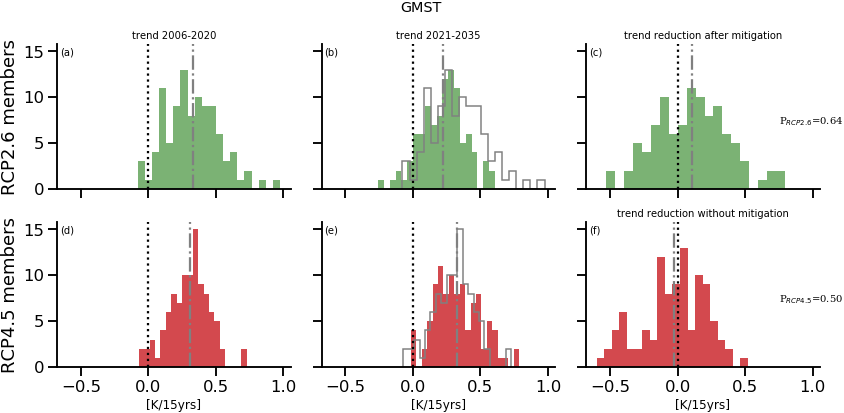

In [109]:
# plot_Marotzke_2019_frequencies(gmst_cdo.rename({'tsurf':'GMST'}),sharex=True,unit='K',obs=obs_trend,obs_label='observed 2004-2018')
plot_Marotzke_2019_frequencies(
    gmst_cdo.rename({"tsurf": "GMST"}), sharex=True, unit="K"
)
plt.show()

In [89]:
def bootstrapping(ds, func, dim="member", bootstrap=5, replacement=True, **func_kwargs):
    """Shuffle the 100 members with replacement bootstrap times."""
    bootstraped_results = []
    dim_to_shuffle = ds[dim].values
    length = len(dim_to_shuffle) // 2
    for _ in trange(bootstrap):
        if replacement:
            smp_dim = np.random.choice(dim_to_shuffle, len(dim_to_shuffle))
        else:
            dim_to_shuffle = ds[dim].values
            smp_dim = np.random.choice(dim_to_shuffle, replace=False, size=length)
            dim_to_shuffle = ds[dim].isel({dim: slice(None, length)}).values
        smp_ds = ds.sel({dim: smp_dim})
        smp_ds[dim] = dim_to_shuffle
        b_res = func(smp_ds, **func_kwargs)
        bootstraped_results.append(b_res)
    res = xr.concat(bootstraped_results, "bootstrap")
    return res

In [90]:
# which trendlength corresponds to which years analyzed?
mid = 2021
lower_end = 1996
diff2006 = mid - lower_end
mintrend = 5
for trendlength in range(mintrend, diff2006 + 1):
    start = mid - trendlength
    end = mid + trendlength - 1
    print(start, mid, end, trendlength)

2016 2021 2025 5
2015 2021 2026 6
2014 2021 2027 7
2013 2021 2028 8
2012 2021 2029 9
2011 2021 2030 10
2010 2021 2031 11
2009 2021 2032 12
2008 2021 2033 13
2007 2021 2034 14
2006 2021 2035 15
2005 2021 2036 16
2004 2021 2037 17
2003 2021 2038 18
2002 2021 2039 19
2001 2021 2040 20
2000 2021 2041 21
1999 2021 2042 22
1998 2021 2043 23
1997 2021 2044 24
1996 2021 2045 25


In [91]:
def over_trendlength(
    gmst_cdo,
    bootstrap=500,
    varname="tsurf",
    mid=2021,
    mintrend=5,
    lower_end=2006,
    **kwargs
):
    ltrendlength = []
    lres = []
    # set 2015 as fixed middle
    # mid=2021
    diff2006 = mid - lower_end
    for trendlength in range(mintrend, diff2006 + 1):
        ltrendlength.append(trendlength)
        start = mid - trendlength
        end = mid + trendlength - 1
        print(start, mid, end, trendlength)
        res = bootstrapping(
            gmst_cdo,
            Marotzke_2019,
            print_res=False,
            start=start,
            end=end,
            output=True,
            combined=True,
            bootstrap=bootstrap,
            **kwargs
        )
        lres.append(res)
    P_gmst = xr.concat(lres, "trendlength")
    P_gmst["trendlength"] = ltrendlength
    return P_gmst

### Figure 3

In [92]:
def plot_P(P, title="GMST", v="tsurf", ax=None, loc="best", causation=True, box=False):
    P = P.where(P >= 0, other=0)
    print(
        ((P.median("bootstrap") > 0.95).argmax("trendlength") + 3).to_dataframe("TDM"),
        "ignore P_RCP45 value",
    )
    P["P"] = ["$P_S$", "$P_N$", "$P_{NS}$", "$P_{RCP2.6}$", "$P_{RCP4.5}$"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    colors = ["steel blue", "medium blue", "dark blue", "faded green", "faded red"]
    cmap = sb.xkcd_palette(colors)
    fac = 100
    mean = P.median("bootstrap") * fac
    ul = P.quantile(psig, "bootstrap") * fac
    ll = P.quantile(1 - psig, "bootstrap") * fac
    res_Marotzke2019 = [0.40, 0.33, 0.22, 0.67, 0.45]
    df = mean.to_dataframe()[v].unstack()

    for i, iP in enumerate(P.P.values):
        yerr = [
            ll.to_dataframe()[v].unstack()[iP] - df[iP],
            df[iP] - ul.to_dataframe()[v].unstack()[iP],
        ]
        if causation:
            df[iP].plot(yerr=yerr, capsize=4, c=cmap[i], marker="o")
        else:
            if iP in ["$P_{RCP2.6}$", "$P_{RCP4.5}$"]:
                df[iP].plot(yerr=yerr, capsize=4, c=cmap[i], marker="o")
    ax = plt.gca()
    ax.set_title(title)
    ax.set_ylim([-5, 105])
    ax.set_ylabel("Probability P [%]")
    ax.set_xlabel("Trend length [years]")
    # ax.axhline(y=50,c='gray',label='')
    ax.set_xlim([df.index.min() - 1, df.index.max() + 1])
    ax.set_xticks(np.arange(df.index.min(), df.index.max() + 1))
    if causation:
        ncol = 2
        legendtitle = "Causation: Trend reduction:"
    else:
        ncol = 1
        legendtitle = "Trend reduction:"
    ax.legend(
        ncol=ncol,
        fontsize="small",
        frameon=False,
        loc=loc,
        title=legendtitle,
        title_fontsize="x-small",
        labelspacing=0.3,
        columnspacing=0.5,
    )
    if title is "GMST":
        for i, p in enumerate(P_gmst.P):
            plt.scatter(15, 100 * res_Marotzke2019[i], marker="x", color=cmap[i])
    ax.axhline(y=95, color="gray", ls=":")
    ax.axhline(y=5, color="gray", ls=":")
    # add box
    if box:
        tdm = (P.median("bootstrap") > 0.95).argmax(
            "trendlength"
        ) + 3  # .to_dataframe('TDM')
        tdm = tdm.where(tdm != 3, 15)
        fig.patches.extend(
            [
                plt.Rectangle(
                    (0.3, 0.1),
                    0.04,
                    0.65,
                    color="gray",
                    fill=False,
                    transform=fig.transFigure,
                    figure=fig,
                )
            ]
        )
        for i, p in enumerate(["$P_S$", "$P_N$"]):
            tdm_tl = mean.sel(P=p, trendlength=tdm.sel(P=p)).values
            ax.annotate(
                f"$TDM_{p[-2]}$",
                fontsize="x-small",
                xy=(tdm.sel(P=p) + 0.1 * (-1) ** i, tdm_tl - 2 * (-1) ** i),
                xytext=(11 + i * 1.5, 90),
                xycoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            )

    sb.despine()
    plt.tight_layout()

In [93]:
# plot_P(P_co2_combined.sel(trendlength=slice(3,15)),title='Diagnosed global atmospheric CO$_2$',causation=False)
# plot_P(P_co2_combined.sel(trendlength=slice(3,15)),title='Diagnosed global atmospheric CO$_2$',causation=True,box=True)

In [94]:
def plot_Marotzke_2019(ds, unit="K", start=2006, end=2035):
    """Plot all."""
    plot_Marotzke_2019_Box_plots(ds, start=start, end=end)
    plot_Marotzke_2019_timeseries(ds, start=start, end=end)
    plot_Marotzke_2019_frequencies(ds, unit=unit, start=start, end=end)

In [95]:
# plot_Marotzke_2019(gmst_cdo)

## GMST

In [96]:
trend_late, trend_early, trendlength, P_S, P_N, P_NS, P_RCP26, P_RCP45 = Marotzke_2019(
    gmst_cdo, print_res=True, output=True
)

Trends 2006 - 2020 2021 - 2035 Trendlength: 15

 events 
        tsurf            
ext    rcp26 rcp45 rcp85
member                  
0       0.14 -0.08 -0.28
1      -0.10  0.09 -0.10
2      -0.16 -0.38 -0.01
3      -0.08 -0.09 -0.19
4      -0.26 -0.42  0.02

 event summary
 ext    rcp26  rcp45  rcp85
tsurf   0.64    0.5   0.35

P_S =
 tsurf    0.28
dtype: float64

P_N =
 tsurf    0.22
dtype: float64

P_NS =
 tsurf    0.14
dtype: float64


In [97]:
trend_late, trend_early, trendlength, P_S, P_N, P_NS, P_RCP26, P_RCP45 = Marotzke_2019(
    gmst_cdo, print_res=False, output=True
)

In [98]:
gmst_obs = pd.read_csv(
    "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat",
    header=None,  # index_col=0,
    sep="\t",
)

In [101]:
# gmst_obs_nc = xr.open_dataset('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.4.6.0.0.median.nc')
gmst_obs_nc = yearmonmean(
    xr.open_dataset(
        "~/PhD_Thesis/PhD_scripts/160701_Grand_Ensemble/HadCRUT.4.6.0.0.median.nc"
    ).sel(time=slice("2000", None))["temperature_anomaly"]
)

In [102]:
gmst_obs_nc = gmst_obs_nc.mean(["longitude", "latitude"])
# gmst_obs_nc.plot()

In [103]:
for s in range(2000, 2005):
    obs_trend = (
        float(
            linear_trend(
                gmst_obs_nc.sel(time=slice(s, s + 14)).to_dataframe("obs").loc[:]
            )
            .loc[0]
            .values
        )
        * 5
    )
    print(f"{s}-{s+14} trend: {obs_trend}")

2000-2014 trend: 0.06397662098918236
2001-2015 trend: 0.06561372588787658
2002-2016 trend: 0.09461596608161967
2003-2017 trend: 0.11042299228054542
2004-2018 trend: 0.10452349803277582


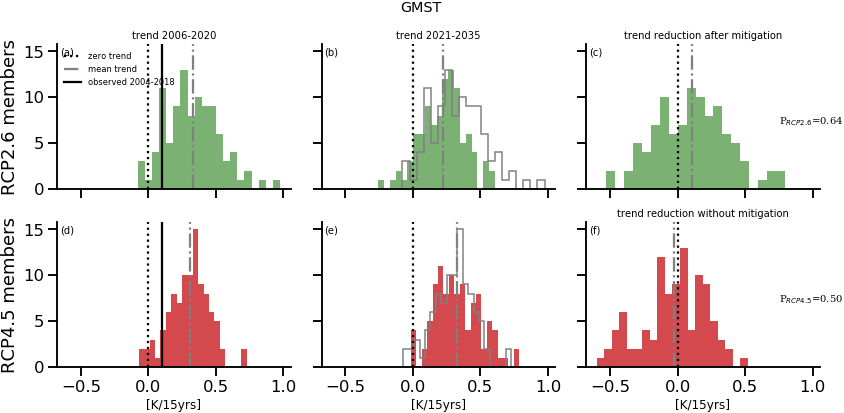

In [104]:
plot_Marotzke_2019_frequencies(
    gmst_cdo.rename({"tsurf": "GMST"}),
    sharex=True,
    unit="K",
    obs=obs_trend,
    obs_label="observed 2004-2018",
)
plt.savefig(paper_path + "FigureSI_15yr_trend_freq_GMST")

In [75]:
bootstrap = 500

In [76]:
# boot_res = bootstrapping(gmst_cdo.load(),Marotzke_2019,print_res=False,output=True,combined=True,
#                         bootstrap=bootstrap, replacement=True)
# boot_res.to_dataframe().unstack().plot.hist(subplots=True,figsize=(5,10),bins=50)

In [105]:
bootstrap = 500
# P_gmst=over_trendlength(gmst_cdo,bootstrap=bootstrap,lower_end=1991,mintrend=3)
# P_gmst.to_netcdf(results_path+'MPIESM_GE_P_GMST_bootstrap_'+str(bootstrap)+'.nc')

In [106]:
P_gmst = xr.open_dataset(
    results_path + "MPIESM_GE_P_GMST_bootstrap_" + str(bootstrap) + ".nc"
)["tsurf"]

         TDM
P           
P_S       27
P_N        3
P_NS       3
P_RCP26   26
P_RCP45    3 ignore P_RCP45 value


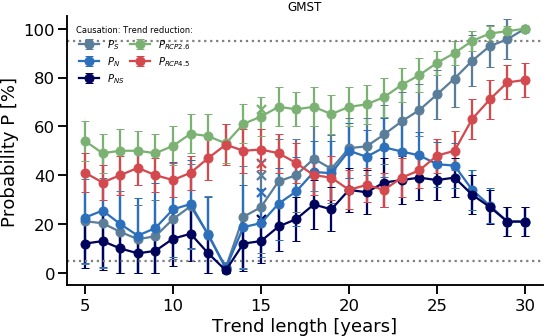

In [107]:
plot_P(P_gmst.sel(trendlength=slice(5, 30)))
plt.xlim([4, 31])
plt.xticks(np.arange(5, 31, 5))
sb.despine()
plt.savefig(paper_path + "FigureSI_Prob_GMST")

Figure Caption: Probabilities of trend reduction and detection & attributation (blues) for GMST based on 100 uninitialized simulations. Errorbars are based on bootstrapping with 500 iterations at the 95% confidence level. For trends longer than 5 years, trend reductions in atmospheric CO$_2$ concentrations significantly differ.

## diagnosed co2atm

In [110]:
obs_co2 = PMMPIESM.load.CO2_global_mean()
obs_co2 = PMMPIESM.setup.yearmonmean(obs_co2)

In [111]:
for s in range(2004, 2015):  # 1990
    obs_trend = (
        float(
            linear_trend(obs_co2.sel(time=slice(s, s + 4)).to_dataframe("obs").loc[:])
            .loc[0]
            .values
        )
        * 5
    )
    print(f"{s}-{s+4} trend: {obs_trend}")

2004-2008 trend: 9.92791666666671
2005-2009 trend: 9.379583333333077
2006-2010 trend: 9.412083333331328
2007-2011 trend: 9.657916666667415
2008-2012 trend: 9.753750000000563
2009-2013 trend: 10.851666666666777
2010-2014 trend: 10.920833333333116
2011-2015 trend: 11.293333333332933
2012-2016 trend: 12.502083333337701
2013-2017 trend: 12.671666666667143
2014-2018 trend: 13.052916666664114


In [112]:
# trend_late, trend_early, trendlength, P_S, P_N, P_NS,P_RCP26, P_RCP45=Marotzke_2019(cf_diagnosed,print_res=True,output=True,start=2016,end=2025)

In [113]:
# quickcheck
v = "co2_flux"
cf_diagnosed = (
    diagnosed.rename({v: "combined"})["combined"]
    .to_dataset()
    .drop("member")
    .rename({"member": "ext", "time": "year", "initialization": "member"})
)
cf_diagnosed["ext"] = gmst_cdo.ext
max_trendlength = 15
lower_end = 2020 - max_trendlength + 1
# P_co2_combined=over_trendlength(cf_diagnosed,bootstrap=10,varname=v,mintrend=3,lower_end=lower_end)
# plot_P(P_co2_combined.sel(trendlength=slice(3,max_trendlength)),title='Diagnosed global atmospheric CO$_2$',loc='best')
# plt.xlim([2,max_trendlength+1])
# sb.despine()

co2_flx_ocean
         TDM
P           
P_S        3
P_N        6
P_NS       6
P_RCP26    3
P_RCP45    3 ignore P_RCP45 value


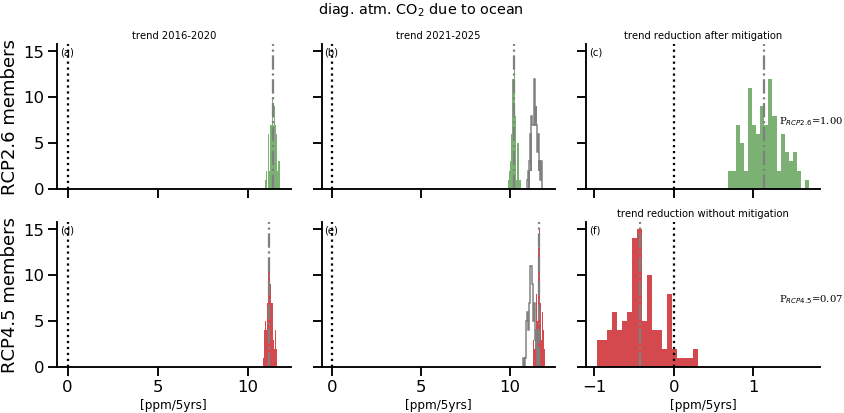

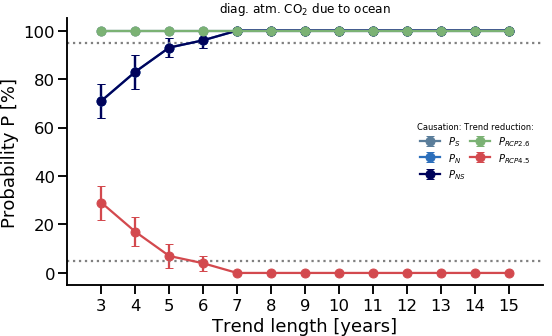

co2_flx_land
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value


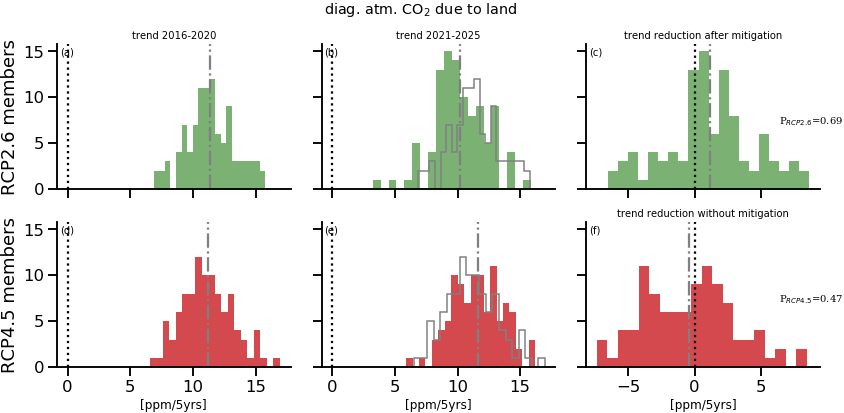

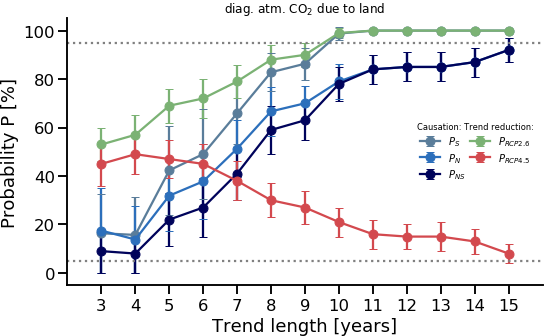

co2_flux
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value


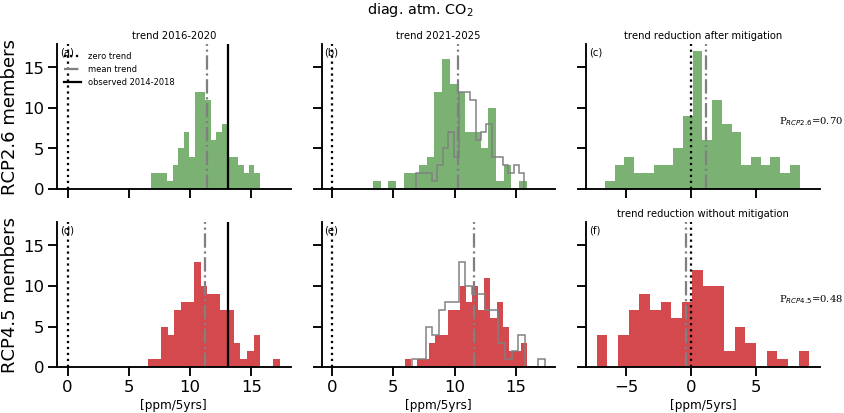

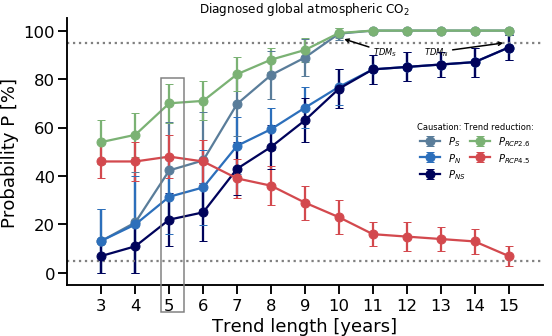

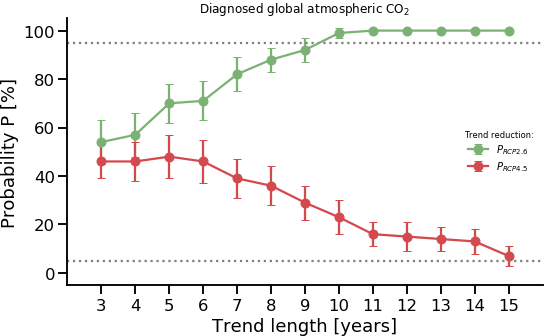

In [114]:
# plot diag CO2 based on co2_flux, co2_flx_land, co2_flx_ocean
start = 2016
end = 2025

for v in list(diagnosed.data_vars)[::-1]:
    print(v)
    cf_diagnosed = (
        diagnosed.rename({v: "combined"})["combined"]
        .to_dataset()
        .drop("member")
        .rename({"member": "ext", "time": "year", "initialization": "member"})
    )
    cf_diagnosed["ext"] = gmst_cdo.ext

    if v == "co2_flux":
        plot_Marotzke_2019_frequencies(
            cf_diagnosed.rename({"combined": "diag. atm. CO$_{2}$"}),
            start=start,
            end=end,
            unit="ppm",
            sharex="col",
            obs=obs_trend,
            obs_label="observed 2014-2018",
        )
        plt.savefig(paper_path + "Figure2_5yr_trend_freq_diag_atm_CO2")
    else:
        plot_Marotzke_2019_frequencies(
            cf_diagnosed.rename({"combined": longname_diag[v]}),
            start=start,
            end=end,
            unit="ppm",
            sharex="col",
        )
        plt.savefig(paper_path + "FigureSI_5yr_trend_freq_diag_atm_" + v)

    bootstrap = 500
    max_trendlength = 15
    lower_end = 2020 - max_trendlength + 1
    # P_co2_combined=over_trendlength(cf_diagnosed,bootstrap=bootstrap,varname=v,mintrend=3,lower_end=lower_end)
    # P_co2_combined.to_netcdf(f'MPIESM_GE_P_diag_CO2_{v}_bootstrap_{bootstrap}.nc')
    P_co2_combined = xr.open_dataset(
        results_path + f"MPIESM_GE_P_diag_CO2_{v}_bootstrap_{bootstrap}.nc"
    )["tsurf"]

    if v == "co2_flux":
        plot_P(
            P_co2_combined.sel(trendlength=slice(3, max_trendlength)),
            title="Diagnosed global atmospheric CO$_2$",
            loc="best",
            box=True,
        )
        plt.xlim([2, max_trendlength + 1])
        sb.despine()
        plt.savefig(paper_path + "Figure3_Prob_diag_atm_CO2")
        # of trend reduction
        plot_P(
            P_co2_combined.sel(trendlength=slice(3, max_trendlength)),
            title="Diagnosed global atmospheric CO$_2$",
            loc="best",
            causation=False,
        )
        plt.xlim([2, max_trendlength + 1])
        sb.despine()
        plt.savefig(paper_path + "Figure3_pre_Prob_diag_atm_CO2")
    else:
        plot_P(
            P_co2_combined.sel(trendlength=slice(3, max_trendlength)),
            title=longname_diag[v],
            loc="best",
        )
        plt.xlim([2, max_trendlength + 1])
        sb.despine()
        plt.savefig(paper_path + "FigureSI_Prob_diag_atm_" + v)
    plt.show()

In [115]:
# dump = Marotzke_2019(cf_diagnosed, print_res=True, output=True, start=start, end=end)

### Fig SI2

In [116]:
co2_growth_rate = pd.read_csv(
    "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_gr_mlo.txt", header=59, sep="   "
)

In [117]:
co2_growth_rate.columns = ["Year", "1", "Ann inc", "2", "unc"]

In [118]:
co2_growth_rate = co2_growth_rate[["Year", "Ann inc", "unc"]].set_index("Year")

In [119]:
# co2_growth_rate["Ann inc"].hist()

In [120]:
co2_growth_rate["Ann inc"].describe()

count    60.000000
mean      1.577667
std       0.672217
min       0.280000
25%       1.037500
50%       1.525000
75%       2.040000
max       3.000000
Name: Ann inc, dtype: float64

In [121]:
model = (
    (
        cf_internal_variability["co2_flux"]
        .sel(time=slice(1958, 2018))
        .sel(member="rcp45", drop=True)
        .cumsum("time")
        / 2.13
        + co2atm_forcing.sel(time=slice(1958, 2018)).isel(member=0, drop=True)
    )
    .diff("time")
    .to_dataframe()
)

In [122]:
model.describe().round(2)

,co2atm
count,6000.00
mean,1.54
std,0.86
min,-1.34
25%,0.94
50%,1.54
75%,2.12
max,5.03


In [123]:
comparison = pd.merge(
    model.describe(),
    co2_growth_rate["Ann inc"].describe(),
    left_index=True,
    right_index=True,
).round(2)
comparison.columns = ["modelled", "observed"]
comparison

,modelled,observed
count,6000.00,60.00
mean,1.54,1.58
std,0.86,0.67
min,-1.34,0.28
25%,0.94,1.04
50%,1.54,1.52
75%,2.12,2.04
max,5.03,3.00


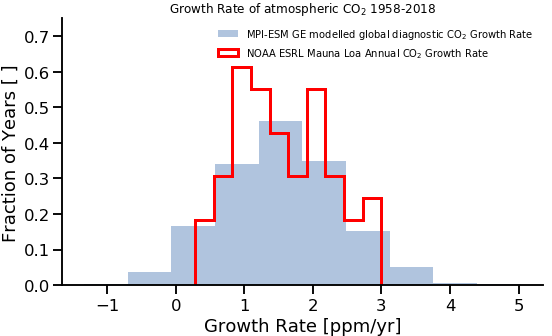

In [124]:
alpha = 1
density = True
fig, ax = plt.subplots(figsize=(8, 5))
model.hist(
    ax=ax,
    density=True,
    color="lightsteelblue",
    label="MPI-ESM GE modelled global diagnostic CO$_2$ Growth Rate",
    alpha=alpha,
)
co2_growth_rate["Ann inc"].hist(
    color="red",
    lw=3,
    histtype="step",
    ax=ax,
    density=True,
    label="NOAA ESRL Mauna Loa Annual CO$_2$ Growth Rate",
    alpha=alpha,
)
plt.legend(frameon=False, fontsize="small")
plt.ylabel("Fraction of Years [ ]")
plt.xlabel("Growth Rate [ppm/yr]")
plt.title("Growth Rate of atmospheric CO$_2$ 1958-2018")
plt.tight_layout()
plt.ylim([0, 0.75])
sb.despine()
ax.grid(False)
plt.savefig(paper_path + "FigureSI_Growth_Rate_distribution")